In [ ]:
!pip install -q pandas
!pip install dask -q
!pip install pyarrow parquet recordlinkage -q
!pip install fastparquet phonetics fuzzywuzzy jellyfish -q
!pip install seaborn
!pip install matplotlib -q 
!pip install pyarrow

import pandas as pd
import recordlinkage as rl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow
import dask.dataframe as dd
# get CPU count
import multiprocessing
CPU_COUNT = multiprocessing.cpu_count()

def attach_ori_feature(to_attach, to_attach_recid_left, to_attach_recid_right, left_df, right_df, suffixes):
    to_attach = to_attach.merge(left_df, left_on = to_attach_recid_left, right_on = 'recid', how = 'left')
    to_attach = to_attach.merge(right_df, left_on = to_attach_recid_right, right_on = 'recid', how = 'left', suffixes = suffixes)
    return to_attach

def plot_feature_importance(fields, feature_importances):
    df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()
import psutil
# Function to report RAM usage
def report_ram_usage():
    process = psutil.Process()
    ram_usage = process.memory_info().rss / (1024 ** 2)  # in MB
    # print(f"Current RAM usage: {ram_usage:.2f} MB")
    # human readable GiB
    print(f"Current RAM usage: {ram_usage / 1024:.2f} GiB")

# Report RAM before starting
report_ram_usage()


## read 1. comparison pool, 2.patent 3.census and 4.gt

In [ ]:
# pool
import pickle
with open("../int_data/compare_pool_ver_0_2_phonetic_correct.pkl", "rb") as f: # suject to future iterations
    partition_result = pickle.load(f)

def get_three_level_idx(partition_result):
    # reset index with names patent_idx and census_idx
    partition_result = partition_result.reset_index().rename(columns={'level_0': 'patent_idx', 'level_1': 'recid'})
    # extract patent_id and patent_count from patent_idx
    partition_result['patent_id'] = partition_result['patent_idx'].apply(lambda x:x[0])
    partition_result['patent_count'] = partition_result['patent_idx'].apply(lambda x:x[1])
    # extract recid and year from census_idx
    # partition_result['recid'] = partition_result['recid'].apply(lambda x:x[0])
    # partition_result['year'] = partition_result['recid'].apply(lambda x:x[1])
    # drop patent_idx and census_idx
    # partition_result.drop(columns=['patent_idx', 'recid'], inplace=True)
    partition_result.drop(columns=['patent_idx'], inplace=True)
    partition_result = partition_result.set_index(['patent_id', 'patent_count', 'recid'])
    return partition_result

partition_result = get_three_level_idx(partition_result)
if 'street_levenshtein' in partition_result.columns:
    partition_result.drop(columns = ['street_levenshtein'], inplace = True)
partition_result = partition_result.reset_index()

In [ ]:
# census
# subSample1851 = dd.read_parquet('../Census_samples/Whole_ipum/Whole_1881').compute() # 17,711,030
_1880 = pd.read_parquet('../int_data/US_Census1880.parquet').rename(columns = {'namefrst':'pname', 'namelast':'sname', 'us1880a_street':'street'})

# convert codes to int
_1880.us1880a_city = _1880.us1880a_city.fillna(0)
_1880.us1880a_city = _1880.us1880a_city.astype('int')

# drop those under 15
_1880 = _1880[_1880['age'] >= 15]

# make recid feature
_1880 = _1880.reset_index().rename(columns = {'index':'recid'})

# patent
patent = pd.read_pickle(f'../int_data/sub_patents_4omini_ver0_2_extrac_first_600_chars_3000_docs.pkl')
# subset US
patent = patent[(patent.foreign != True)].reset_index(drop = True)

# make street upper 
patent.street = patent.street.apply(lambda x:x.upper() if x else x)

# make capital
patent['name'] =patent.name.apply(lambda x:x.upper() if x else x)
patent['pname']=patent.name.apply(lambda x:' '.join(x.split(' ')[:-1]) if x else x)
patent['sname'] =patent.name.apply(lambda x:x.split(' ')[-1] if x else x)

# assign index
patent = patent.drop_duplicates(subset= ['publicationnumber', 'inventor_no'])
assert patent.set_index(['publicationnumber', 'inventor_no']).index.is_unique
patent

In [ ]:
_1880[['pname', 'sname']]

In [ ]:
# gt = pd.read_csv("../aux_data/GPT4o_Historical_American_Inventors_Data__1870-1890_.csv") # ChatGPT: 
gt = pd.read_csv("../int_data/final_sample3000_ver0_2.csv") # Alternatively, use a subset of this sample
gt_manual_label = pd.read_csv("../aux_data/GT_MANUAL_162.csv")  
gt_manual_label = gt_manual_label[gt_manual_label['gt'] == True]
gt = gt.loc[gt_manual_label.index] # A subset of final_sample3000_ver0_2

In [ ]:
# filter out where patent pname and sname are NaN or UNKOWN
def filter_out_unknown_patent_names(df):
    # import pandas as pd
    # mask = ((pd.isna(df.pname)| df.pname.str.upper() == 'NAN') & df.sname.str.upper() == 'UNKNOWN')

    # import numpy as np
    # mask = ((df.pname == np.nan | df.pname.str.upper() == 'NAN') & df.sname.str.upper() == 'UNKNOWN')

    mask = (df.sname.str.upper() == 'UNKNOWN')    
    print(mask.value_counts())
    return df.loc[~mask]

gt = filter_out_unknown_patent_names(gt)
gt[gt.pname.isna()][['pname', 'sname', 'pname_census', 'sname_census', 'pname_pname_jarowinkler', 'sname_sname_jarowinkler']]

In [ ]:

gt.pname = gt.pname.apply(str.upper)
gt.sname = gt.sname.apply(str.upper)

# # merge gt with patent
# gt = pd.merge(gt, patent, on = ['pname', 'sname'], how = 'left') # No conplete patent for now
# gt

# merge gt with census
# gt = pd.merge(gt, _1880, on = ['pname', 'sname'], how = 'left') # No conplete patent for now
# gt

In [ ]:
gt.columns, patent.columns, _1880.columns

## merge using unique identifiers

In [ ]:
def attach_ori_feature(to_attach, to_attach_recid_left, to_attach_recid_right, left_df, right_df, suffixes):
    to_attach = to_attach.merge(left_df, left_on = to_attach_recid_left, right_on = 'recid', how = 'left')
    to_attach = to_attach.merge(right_df, left_on = to_attach_recid_right, right_on = 'recid', how = 'left', suffixes = suffixes)
    return to_attach

attached_comparison_pool = partition_result.reset_index()
# we want to attach column from right to the left, so 'left' join
attached_comparison_pool = pd.merge(left = partition_result , right = patent, left_on = ['patent_id', 'patent_count'], right_on =['publicationnumber', 'inventor_no'], how ='left') 
attached_comparison_pool = pd.merge(left = attached_comparison_pool , right = _1880, on = 'recid', how ='left', suffixes = ['patent', 'census'])

attached_comparison_pool

In [49]:
_1880.recid.sort_values()

0                  0
1                  1
2                  8
3                  9
4                 14
              ...   
34643733    56022508
34643734    56022511
34643735    56022512
34643736    56022513
34643737    56022519
Name: recid, Length: 34643738, dtype: int64

In [50]:
attached_comparison_pool.description.isna().sum(), attached_comparison_pool.occhisco.isna().sum()

(0, 4056114)

In [51]:
gt

,patent_id,patent_count,recid,pname_pname_jarowinkler,sname_sname_jarowinkler,county_state_county_state_levenshtein,desc_ori_hisco_text_levenshtein,occ_similarity_HISCO,city/metro_level_l_score,mean,...,sex_census,occhisco,ind95us,county_state_census,metrous,us1880a_city,state_census,patent_year,age_at_inventing,occ_similarity_HISCO_sigmoid
0,US290029A,0.0,25137783.0,1.000000,1.00,0.958333,1.000000,1.0,0.818182,0.962753,...,1.0,2410.0,898.0,"St Louis City, Missouri",St. Louis,Saint Louis,Missouri,1883,35.0,0.731059
2,US265109A,0.0,19319070.0,0.950000,1.00,1.000000,0.689189,NaN,1.000000,0.927838,...,1.0,39000.0,699.0,"Suffolk, Massachusetts",Boston,Boston,Massachusetts,1882,36.0,NaN
3,US169225A,0.0,39793614.0,1.000000,1.00,1.000000,1.000000,1.0,0.500000,0.916667,...,1.0,87350.0,346.0,"Lycoming, Pennsylvania",NaN,Williamsport,Pennsylvania,1875,37.0,0.731059
4,US359565A,0.0,16967309.0,1.000000,1.00,1.000000,1.000000,1.0,0.500000,0.916667,...,1.0,19990.0,899.0,"York, Maine",NaN,NaN,Maine,1887,42.0,0.731059
5,US264407A,0.0,12283425.0,1.000000,1.00,1.000000,1.000000,1.0,0.500000,0.916667,...,1.0,19990.0,356.0,"Montgomery, Iowa",NaN,NaN,Iowa,1882,36.0,0.731059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,US408600A,0.0,19448452.0,0.914286,1.00,1.000000,0.176471,NaN,1.000000,0.818151,...,1.0,99999.0,0.0,"Suffolk, Massachusetts",Boston,Boston,Massachusetts,1889,24.0,NaN
152,US305112A,0.0,2567467.0,0.950000,1.00,1.000000,0.233333,1.0,0.724138,0.817912,...,1.0,79120.0,656.0,"San Francisco, California",San Francisco-Oakland-Vallejo,San Francisco,California,1884,40.0,0.731059
154,US100335A,0.0,40872177.0,1.000000,1.00,0.576923,0.509804,NaN,1.000000,0.817345,...,1.0,75400.0,438.0,"Philadelphia, Pennsylvania",Philadelphia,Philadelphia,Pennsylvania,1870,40.0,NaN
156,US294666A,0.0,35323303.0,0.955556,0.95,1.000000,0.179487,NaN,1.000000,0.817009,...,1.0,53100.0,0.0,"Hamilton, Ohio",Cincinnati,Cincinnati,Ohio,1884,54.0,NaN


In [52]:
# filter out where patent pname and sname are NaN or UNKOWN
def filter_out_unknown_patent_names(df):
    # import pandas as pd
    # mask = ((pd.isna(df.pname)| df.pname.str.upper() == 'NAN') & df.sname.str.upper() == 'UNKNOWN')

    # import numpy as np
    # mask = ((df.pname == np.nan | df.pname.str.upper() == 'NAN') & df.sname.str.upper() == 'UNKNOWN')

    mask = (df.sname.str.upper() == 'UNKNOWN')    
    print(mask.value_counts())
    return df.loc[~mask]

gt = filter_out_unknown_patent_names(gt)
gt[gt.pname.isna()][['pname', 'sname', 'pname_census', 'sname_census', 'pname_pname_jarowinkler', 'sname_sname_jarowinkler']]

sname
False    96
Name: count, dtype: int64


,pname,sname,pname_census,sname_census,pname_pname_jarowinkler,sname_sname_jarowinkler


In [53]:

gt.pname = gt.pname.apply(str.upper)
gt.sname = gt.sname.apply(str.upper)

# # merge gt with patent
# gt = pd.merge(gt, patent, on = ['pname', 'sname'], how = 'left') # No conplete patent for now
# gt

# merge gt with census for looking at GPT-generated gt
# gt = pd.merge(gt, _1880, on = ['pname', 'sname'], how = 'left') # No conplete patent for now
# gt

In [54]:
# Convert MultiIndex to DataFrame
gt = gt.reset_index(drop=True).reset_index(drop = True)

# get the first 50 rows (highest matching score) of gt df to be the true gt # TODO: manual selection of, say, 50
if gt.shape[0] > 50:
    gt = gt[:50]

gt_index = gt.set_index(['patent_id', 'patent_count', 'recid']).index

In [55]:
gt_index

MultiIndex([('US290029A', 0.0, 25137783.0),
            ('US265109A', 0.0, 19319070.0),
            ('US169225A', 0.0, 39793614.0),
            ('US359565A', 0.0, 16967309.0),
            ('US264407A', 0.0, 12283425.0),
            ('US333683A', 0.0, 21799940.0),
            ('US182331A', 0.0, 19403994.0),
            ('US181776A', 0.0, 40891400.0),
            ('US129323A', 1.0, 40926575.0),
            ('US393010A', 0.0, 41022510.0),
            ('US156398A', 0.0, 40248992.0),
            ('US210330A', 0.0,  4145619.0),
            ('US285547A', 0.0, 40249528.0),
            ('US174526A', 0.0, 40575518.0),
            ('US300477A', 0.0, 40845981.0),
            ('US324279A', 0.0, 40556121.0),
            ('US264348A', 0.0, 40743191.0),
            ('US287919A', 1.0,  6732572.0),
            ('US400916A', 0.0, 40368263.0),
            ('US412601A', 0.0, 29672721.0),
            ('US303389A', 0.0, 40616478.0),
            ('US145216A', 1.0, 40422898.0),
            ('US241172A', 0.0, 1

In [56]:
report_ram_usage()

Current RAM usage: 28.80 GiB


## Filtering matching pool: Otherwise the dataset is too large
To get records with at least one of patent_id, patent_count and recid that is within the gt.  
Sub-sampling non-ground-truth can also make the sample small enough for training, but this filtering strategy worked quite well last time. 
1. It helps the model to learn the key difference in similar (either patent side or census side is in ground truth but not both.
2. It natually scales down the comparison pool according to the size of gt

In [57]:
attached_comparison_pool.columns

Index(['patent_id', 'patent_count', 'recid', 'pname_pname_jarowinkler',
       'sname_sname_jarowinkler', 'county_state_county_state_levenshtein',
       'city_metrous_levenshtein', 'city_us1880a_city_levenshtein',
       'desc_ori_hisco_text_levenshtein', 'occ_similarity_HISCO', 'index',
       'publicationnumber', 'X', 'Publication.date', 'Title', 'description',
       'year', 'parsed_desc', 'prompt_tokens', 'completion_tokens',
       'total_tokens', 'cost', 'parsed_desc_parsed', 'parsed_desc_type',
       'inventors', 'name', 'sexpatent', 'occupation', 'industry', 'address',
       'streetpatent', 'city', 'county', 'state', 'region', 'foreign',
       'full_address', 'fsull_address', 'pnamepatent', 'snamepatent',
       'inventor_no', 'pnamecensus', 'snamecensus', 'sursim', 'age',
       'sexcensus', 'occhisco', 'ind95us', 'enumdist', 'countyus', 'metrous',
       'us1880a_region', 'us1880a_stateicp', 'us1880a_city',
       'us1880a_stcounty', 'us1880a_county', 'streetcensus'],
   

In [58]:
attached_comparison_pool['patent_count'] = attached_comparison_pool.patent_count.astype('int64')
attached_comparison_pool['recid'] = attached_comparison_pool.recid.astype('int64')

filtered_pool = attached_comparison_pool[(attached_comparison_pool.patent_id.isin(gt_index.get_level_values(0).unique()) & attached_comparison_pool.patent_count.isin(gt_index.get_level_values(1).unique())) | attached_comparison_pool.recid.isin(gt_index.get_level_values(2).unique())]
filtered_pool['good'] = False
filtered_pool = filtered_pool.set_index(['patent_id', 'patent_count', 'recid'])
filtered_pool.loc[gt_index, 'good'] = True
filtered_pool = filtered_pool.reset_index()

/tmp/ipykernel_14545/2596712435.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pool['good'] = False


In [59]:
filtered_pool.good.value_counts()

good
False    280814
True         50
Name: count, dtype: int64

## Data Augmentation on true-matches (in the first iteration) Using SMOTE

In [60]:
filtered_pool.columns

Index(['patent_id', 'patent_count', 'recid', 'pname_pname_jarowinkler',
       'sname_sname_jarowinkler', 'county_state_county_state_levenshtein',
       'city_metrous_levenshtein', 'city_us1880a_city_levenshtein',
       'desc_ori_hisco_text_levenshtein', 'occ_similarity_HISCO', 'index',
       'publicationnumber', 'X', 'Publication.date', 'Title', 'description',
       'year', 'parsed_desc', 'prompt_tokens', 'completion_tokens',
       'total_tokens', 'cost', 'parsed_desc_parsed', 'parsed_desc_type',
       'inventors', 'name', 'sexpatent', 'occupation', 'industry', 'address',
       'streetpatent', 'city', 'county', 'state', 'region', 'foreign',
       'full_address', 'fsull_address', 'pnamepatent', 'snamepatent',
       'inventor_no', 'pnamecensus', 'snamecensus', 'sursim', 'age',
       'sexcensus', 'occhisco', 'ind95us', 'enumdist', 'countyus', 'metrous',
       'us1880a_region', 'us1880a_stateicp', 'us1880a_city',
       'us1880a_stcounty', 'us1880a_county', 'streetcensus', 'goo

In [61]:
# cluster_features = ['pname_pname_jarowinkler',
#        'sname_sname_jarowinkler', 'county_state_county_state_levenshtein',
#        'city_metrous_levenshtein', 'city_us1880a_city_levenshtein',
#        'desc_ori_hisco_text_levenshtein', 'occ_similarity_HISCO'] # With HISCO related features; "loopy" as the matching task's aim is to get HISCO for each patent. Filippo & Olmo: don't use this a feature, but reserve for evaluation

cluster_features = ['pname_pname_jarowinkler',
       'sname_sname_jarowinkler', 'county_state_county_state_levenshtein',
       'city_metrous_levenshtein', 'city_us1880a_city_levenshtein'] # Without HISCO related features

In [62]:
filtered_pool[cluster_features].isna().sum()

pname_pname_jarowinkler                  0
sname_sname_jarowinkler                  0
county_state_county_state_levenshtein    0
city_metrous_levenshtein                 0
city_us1880a_city_levenshtein            0
dtype: int64

In [63]:
# filtered_pool.occ_similarity_HISCO.hist() # occ-sim needs normalisation


In [64]:
from imblearn.over_sampling import SMOTE
# SMOTE does not accept missing values encoded as NaN natively, impute before hand
X = filtered_pool[cluster_features]
y = filtered_pool['good']
smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=42, n_jobs = 32) # ratio control: "sampling_strategy" how does 
X_balanced, y_balanced = smote.fit_resample(X, y)

/users/xiet13/.local/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [65]:
X_balanced

,pname_pname_jarowinkler,sname_sname_jarowinkler,county_state_county_state_levenshtein,city_metrous_levenshtein,city_us1880a_city_levenshtein
0,0.550000,0.76,0.64,0.000000,0.0
1,0.490079,0.76,0.64,0.000000,0.0
2,0.324074,0.76,0.64,0.000000,0.0
3,0.422619,0.73,0.64,0.000000,0.0
4,0.438131,0.73,0.64,0.000000,0.0
...,...,...,...,...,...
561623,0.950000,1.00,1.00,1.000000,1.0
561624,1.000000,1.00,1.00,1.000000,1.0
561625,1.000000,1.00,1.00,1.000000,1.0
561626,0.959361,1.00,1.00,0.237059,1.0


## Train (weaker learners)

In [66]:
# cluster_features = ['pname', 'oname', 'sname', 'pname_soundex', 'sname_soundex', 'pname_metaphone', 'sname_metaphone', 'address', 'dateofbirth', 'par_witin_10km', 'birth_par_witin_10km', 'sname_pop_metaphone', 'sex']
# filtered_good = filtered_pool[filtered_pool.good == True]
# filtered_bad = filtered_pool[filtered_pool.good == False]

In [67]:
X_balanced.columns

Index(['pname_pname_jarowinkler', 'sname_sname_jarowinkler',
       'county_state_county_state_levenshtein', 'city_metrous_levenshtein',
       'city_us1880a_city_levenshtein'],
      dtype='object')

In [68]:
import copy
x_y = copy.deepcopy(X_balanced)
x_y['Y'] = y_balanced
# x_y = x_y.rename(columns = {'pname_metaphone':'pname_mtp', 'sname_metaphone':'sname_mtp', 'sname_pop_metaphone':'sname_pop_mtp'})
# temp = x_y.columns.tolist()
# temp.remove('pname_soundex')
# temp.remove('sname_soundex')
# temp.remove('oname')
# temp

In [69]:
# x_y[temp]
x_y.Y.value_counts()

Y
False    280814
True     280814
Name: count, dtype: int64

In [70]:
y_balanced.value_counts()

good
False    280814
True     280814
Name: count, dtype: int64

#### Train

In [71]:
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
# import xgboost

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
model_zoo = {}

In [72]:
X_balanced

,pname_pname_jarowinkler,sname_sname_jarowinkler,county_state_county_state_levenshtein,city_metrous_levenshtein,city_us1880a_city_levenshtein
0,0.550000,0.76,0.64,0.000000,0.0
1,0.490079,0.76,0.64,0.000000,0.0
2,0.324074,0.76,0.64,0.000000,0.0
3,0.422619,0.73,0.64,0.000000,0.0
4,0.438131,0.73,0.64,0.000000,0.0
...,...,...,...,...,...
561623,0.950000,1.00,1.00,1.000000,1.0
561624,1.000000,1.00,1.00,1.000000,1.0
561625,1.000000,1.00,1.00,1.000000,1.0
561626,0.959361,1.00,1.00,0.237059,1.0


#### rm

Accuracy: 0.9991542474582911


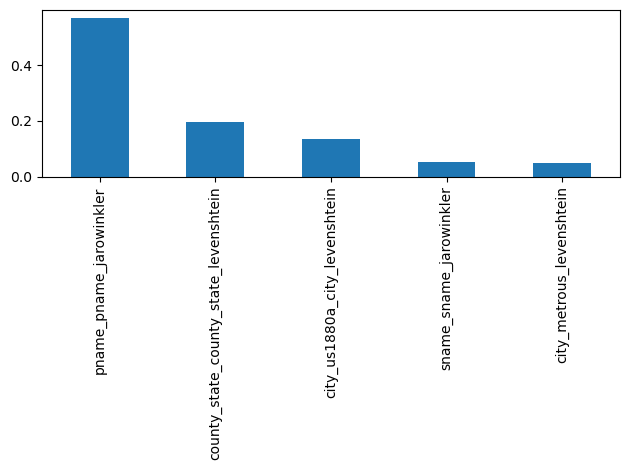

In [73]:
# Initialize and train the classifier
rm = RandomForestClassifier(random_state=42)
rm.fit(X_train, y_train)

# Evaluate the model
y_pred = rm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}") # Accuracy: 0.9966422086805123

# get feature importance
feature_importances = rm.feature_importances_
plot_feature_importance(X_train.columns, feature_importances)

# add to model_zoo
model_zoo['rf'] = rm

In [80]:
# # visualise the tree
# !pip install pydot graphviz -q
# from sklearn.tree import export_graphviz
# import pydot
# import graphviz
# from IPython.display import Image

# # plot
# dot_data = export_graphviz(rm.estimators_[0], out_file=None, feature_names=X_train.columns, filled=True, rounded=True, special_characters=True)
# graph = graphviz.Source(dot_data)
# graph.render("tree")

#### xgboost

Accuracy: 0.9982283709915781


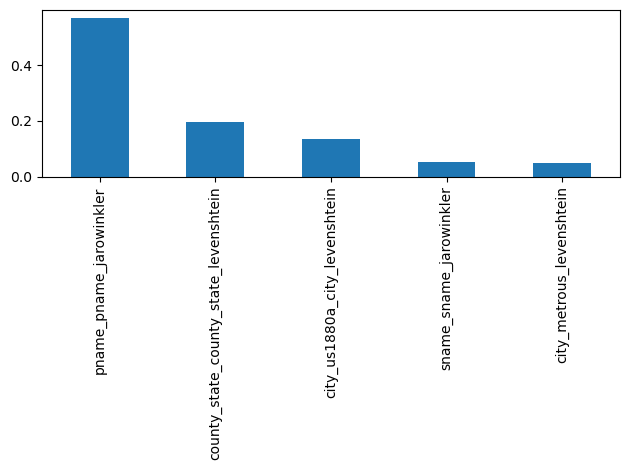

In [75]:
import xgboost as xgb
best_params = {'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 400}
xgb = xgb.XGBClassifier(random_state=42, **best_params)
xgb.fit(X_train, y_train)
# get importance
import matplotlib.pyplot as plt


importance = xgb.feature_importances_

# Evaluate the model
y_pred = xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}") # Accuracy: 0.9973883845292874

# Create a bar plot
plot_feature_importance(X_train.columns, feature_importances)
# add to model_zoo
model_zoo['xgb'] = xgb


#### Bayesian

In [76]:
from sklearn.naive_bayes import GaussianNB


best_params = {'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}
# customise params grid
params_grid = {
    'priors': ['array-like', None],
 'var_smoothing':[1e-09, 2e-09, 1e-07, 1e-06, 1e-05]
}
def train(clf, params_grid):
    '''train using grid search'''
    clf = GridSearchCV(clf, params_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, refit=True)
    clf.fit(X_train, y_train)
    print(clf.best_params_)
    return clf.best_params_, clf
train(GaussianNB(), params_grid)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'priors': None, 'var_smoothing': 1e-09}


/users/xiet13/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/users/xiet13/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/users/xiet13/.local/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/users/xiet13/.local/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/users/xiet13/.

({'priors': None, 'var_smoothing': 1e-09},
 GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
              param_grid={'priors': ['array-like', None],
                          'var_smoothing': [1e-09, 2e-09, 1e-07, 1e-06, 1e-05]},
              scoring='accuracy', verbose=2))

In [77]:
gnb_best_params = {'priors': None, 'var_smoothing': 1e-05}
gnb = GaussianNB(**gnb_best_params)
# train using grid search
gnb.fit(X_train, y_train)
# predict 
y_pred = gnb.predict(X_test)
preds_proba = gnb.predict_proba(X_test)
# accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

# add to model_zoo
model_zoo['gnb'] = gnb

Accuracy: 0.962991649306483


#### lgbm

[LightGBM] [Info] Number of positive: 224611, number of negative: 224691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 449302, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499911 -> initscore=-0.000356
[LightGBM] [Info] Start training from score -0.000356
Accuracy: 0.9984954507415914


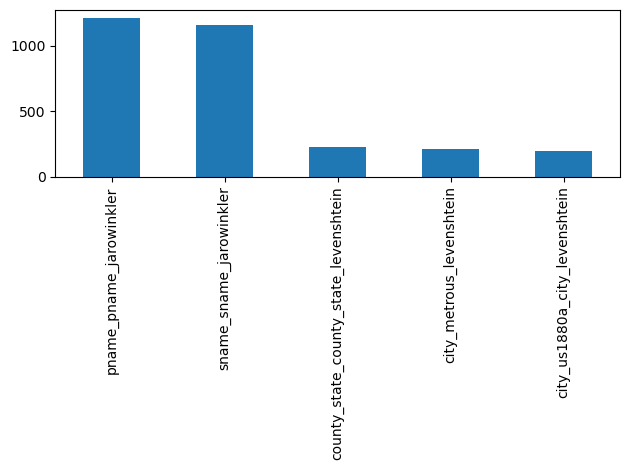

In [79]:
# import LGBMClassifier
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
# predict
y_pred = lgbm.predict(X_test)
preds_proba = lgbm.predict_proba(X_test)
# accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

# get feature importance
feature_importances = lgbm.feature_importances_
plot_feature_importance(X_train.columns, feature_importances)

# add to model_zoo
model_zoo['lgbm'] = lgbm

#### catboost

In [78]:

import catboost as cb
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

# what does cv do?
# Initialize CatBoostClassifier
cb = CatBoostClassifier(iterations=200,
                           learning_rate=0.1,
                           depth=5,
                           loss_function='Logloss',
                           verbose=True)

# Fit model
cb.fit(X_train, y_train)

# Get predicted classes "str"
preds_class = [eval(e) for e in cb.predict(X_test)]
# Get predicted probabilities for each class
preds_proba = cb.predict_proba(X_test)
# Get predicted RawFormulaVal
preds_raw = cb.predict(X_test, 
                          prediction_type='RawFormulaVal')

# accuracy
acc = accuracy_score(y_test, preds_class)
print(f"Accuracy: {acc}") # Accuracy: 

0:	learn: 0.4010617	total: 60.2ms	remaining: 12s
1:	learn: 0.2498531	total: 71.8ms	remaining: 7.11s
2:	learn: 0.1661314	total: 83.1ms	remaining: 5.45s
3:	learn: 0.1167401	total: 94.1ms	remaining: 4.61s
4:	learn: 0.0835768	total: 105ms	remaining: 4.1s
5:	learn: 0.0639527	total: 116ms	remaining: 3.75s
6:	learn: 0.0523978	total: 126ms	remaining: 3.47s
7:	learn: 0.0442712	total: 137ms	remaining: 3.28s
8:	learn: 0.0382707	total: 147ms	remaining: 3.13s
9:	learn: 0.0339370	total: 158ms	remaining: 2.99s
10:	learn: 0.0311626	total: 168ms	remaining: 2.88s
11:	learn: 0.0284369	total: 178ms	remaining: 2.8s
12:	learn: 0.0267901	total: 189ms	remaining: 2.72s
13:	learn: 0.0252773	total: 200ms	remaining: 2.65s
14:	learn: 0.0241954	total: 210ms	remaining: 2.59s
15:	learn: 0.0232984	total: 219ms	remaining: 2.52s
16:	learn: 0.0226527	total: 229ms	remaining: 2.47s
17:	learn: 0.0216088	total: 241ms	remaining: 2.43s
18:	learn: 0.0209892	total: 251ms	remaining: 2.39s
19:	learn: 0.0204398	total: 262ms	remaini

SyntaxError: invalid non-printable character U+0001 (<string>, line 1)

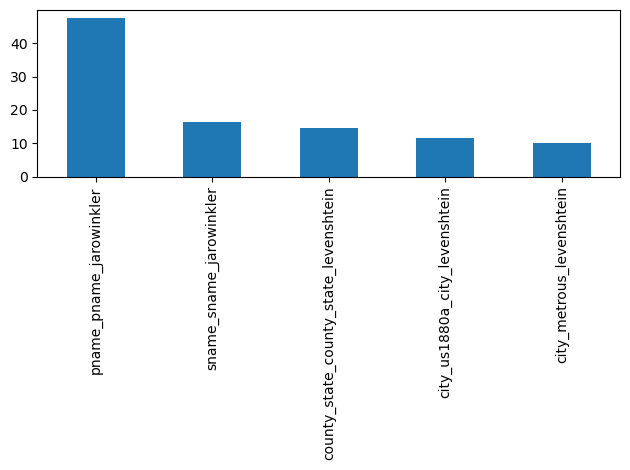

In [81]:
# feature importance
plot_feature_importance(X_train.columns, cb.feature_importances_)

# add to model_zoo
model_zoo['cb'] = cb

In [82]:
# model_dir = f'../model/'
# os.makedirs('../model/patent_census_match', exist_ok = True)
# if model_dir not in os.listdir('../model/patent_census_match/smoted_6_models_5_cols'):
#     os.mkdir(model_dir)
# # save model_zoo separately with a contet

import os
import pickle

model_dir = '../model/patent_census_match/smoted_5_models_5_cols'
os.makedirs(model_dir, exist_ok = True)
for key, value in model_zoo.items():
    with open(f'{model_dir}/{key}.pkl', 'wb') as f:
        pickle.dump(value, f)

#### Pred using weak learners

In [83]:
# read back
import pickle
import os
from dask_ml.wrappers import ParallelPostFit

model_dir = '../model/patent_census_match/smoted_5_models_5_cols'
model_zoo = {}

# read all models in the model_dir
for model in os.listdir(model_dir):
    with open(f'{model_dir}/{model}', 'rb') as handle:
        # model_zoo[model.split('.')[0]] = pickle.load(handle)
        model_zoo[model.split('.')[0]] = ParallelPostFit(pickle.load(handle))
        # predict using dask version sklearn
        # model = ParallelPostFit(model)
        handle.close()


[CV] END .............priors=array-like, var_smoothing=1e-07; total time=   0.0s
[CV] END .............priors=array-like, var_smoothing=1e-09; total time=   0.0s
[CV] END .............priors=array-like, var_smoothing=1e-06; total time=   0.0s
[CV] END .............priors=array-like, var_smoothing=1e-09; total time=   0.0s
[CV] END .............priors=array-like, var_smoothing=1e-09; total time=   0.0s
[CV] END .............priors=array-like, var_smoothing=1e-06; total time=   0.0s
[CV] END ...................priors=None, var_smoothing=1e-09; total time=   0.1s
[CV] END ...................priors=None, var_smoothing=1e-09; total time=   0.1s
[CV] END ...................priors=None, var_smoothing=2e-09; total time=   0.1s
[CV] END ...................priors=None, var_smoothing=1e-09; total time=   0.1s
[CV] END ...................priors=None, var_smoothing=2e-09; total time=   0.1s
[CV] END ...................priors=None, var_smoothing=1e-09; total time=   0.1s
[CV] END ...................

In [85]:
# concat into sample
sample = pd.concat([X_balanced, y_balanced], axis = 1)
sample

,pname_pname_jarowinkler,sname_sname_jarowinkler,county_state_county_state_levenshtein,city_metrous_levenshtein,city_us1880a_city_levenshtein,good
0,0.550000,0.76,0.64,0.000000,0.0,False
1,0.490079,0.76,0.64,0.000000,0.0,False
2,0.324074,0.76,0.64,0.000000,0.0,False
3,0.422619,0.73,0.64,0.000000,0.0,False
4,0.438131,0.73,0.64,0.000000,0.0,False
...,...,...,...,...,...,...
561623,0.950000,1.00,1.00,1.000000,1.0,True
561624,1.000000,1.00,1.00,1.000000,1.0,True
561625,1.000000,1.00,1.00,1.000000,1.0,True
561626,0.959361,1.00,1.00,0.237059,1.0,True


In [86]:

# predict per model in model_zoo and concat the quantile of f'{name}_proba' of each model into df
stats = pd.DataFrame()
for name, model in model_zoo.items():
    sample[f'{name}_proba'] = model_zoo[name].predict_proba(sample[cluster_features])[:, 1]
#     stats = pd.concat([stats, sample.groupby('good')[f'{name}_proba'].quantile([0.05, 0.5, 0.95]).reset_index()], axis = 1)
# stats

In [87]:
masks = {}
for name, _ in model_zoo.items():
    masks[name] = sample[f'{name}_proba'] > 0.5

In [88]:
for name, mask in masks.items():
    print(f"Precision for {name} (TP / TP + FP): {sample[mask & (sample.good == True)].shape[0] / sample[mask].shape[0]}")
    print(f"Recall for {name} (TP / TP + FN): {sample[mask & (sample.good == True)].shape[0] / sample[sample.good == True].shape[0]}")

Precision for gnb (TP / TP + FP): 0.9955265717064241
Recall for gnb (TP / TP + FN): 0.9295904050367859
Precision for cb (TP / TP + FP): 0.9974209866324693
Recall for cb (TP / TP + FN): 0.999868240187455
Precision for xgb (TP / TP + FP): 0.9974656908569377
Recall for xgb (TP / TP + FN): 0.999330517709231
Precision for rf (TP / TP + FP): 0.9988972092278686
Recall for rf (TP / TP + FN): 0.9999323395557201
Precision for lgbm (TP / TP + FP): 0.997438557350026
Recall for lgbm (TP / TP + FN): 0.9998112629712194


In [98]:
name = "80"
# sample.to_csv(f'../Output/temp/{name}_sample_proba_5models.csv')
sample.to_csv(f'../int_data/temp/{name}_sample_proba_5models_SMOTED.csv', index = False)

In [ ]:
# read back
name = "80"
# sample = pd.read_csv(f'../Output/temp/{name}_sample_proba_5models.csv')
sample = pd.read_csv(f'../int_data/temp/{name}_sample_proba_5models_SMOTED.csv')

#### Ensemble Manual

In [3]:
# model_zoo = {'rf': None, 'xgb': None, 'gnb': None}
# name = "61-51"
# for model, _ in model_zoo.items():
#     # reead onlyl several columns
#     model_zoo[model] = dd.read_parquet(f'../Output/pred_bt_{name}_13cols_smoted_true{model}/', columns=['recid_1', 'recid_2', 'pred']).compute().set_index(['recid_1', 'recid_2']).index

In [60]:
# # for every model's prediction, select those with mask_pop_name, mask_mom_name, mask_sp_name == True and concat true predictions
# columns_for_filtering = ['recid', 'pname_pop_soundex', 'sname_pop_soundex', 'pname_mom_soundex', 'sname_mom_soundex', 'pname_sp_soundex', 'sname_sp_soundex']

# def select_high_quality_true(pred_look):
#     mask_pop_name = ((pred_look.pname_pop_soundex_61 == pred_look.pname_pop_soundex_51) & (pred_look.sname_pop_soundex_61 == pred_look.sname_pop_soundex_51)) | (pred_look.pname_pop_soundex_61.isna() | pred_look.pname_pop_soundex_51.isna())
#     mask_mom_name = ((pred_look.pname_mom_soundex_61 == pred_look.pname_mom_soundex_51) & (pred_look.sname_mom_soundex_61 == pred_look.sname_mom_soundex_51)) | (pred_look.pname_mom_soundex_61.isna() | pred_look.pname_mom_soundex_51.isna())
#     mask_sp_name = ((pred_look.pname_sp_soundex_61 == pred_look.pname_sp_soundex_51) & (pred_look.sname_sp_soundex_61 == pred_look.sname_sp_soundex_51)) | (pred_look.pname_sp_soundex_61.isna() | pred_look.pname_sp_soundex_51.isna())

#     return pred_look[mask_pop_name & mask_mom_name & mask_sp_name]

# concated_pred = pd.DataFrame()
# for model, _ in model_zoo.items():
#     # mask_pred_true = sample[f'{model}_pred']
#     # concated_pred = pd.concat([concated_pred, select_high_quality_true(sample, model)])
#     pred_idx = model_zoo[model]
#     pred = attach_ori_feature(pred_idx.to_frame().reset_index(drop=True).reset_index(drop = True), 'recid_1', 'recid_2', subSample1861[columns_for_filtering], subSample1851[columns_for_filtering], ['_61', '_51'])
#     concated_pred = pd.concat([concated_pred, select_high_quality_true(pred)])
#     del pred
#     concated_pred = concated_pred.drop_duplicates(subset = ['recid_2'])
#     concated_pred = concated_pred.drop_duplicates(subset = ['recid_1'])



In [66]:
# # find intersection of all models
# intersec_ensemble_rf = model_zoo['rf'].intersection(concated_pred.set_index(['recid_1', 'recid_2']).index)
# intersec_ensemble_xgb = model_zoo['xgb'].intersection(concated_pred.set_index(['recid_1', 'recid_2']).index)
# intersec_ensemble_gnb = model_zoo['gnb'].intersection(concated_pred.set_index(['recid_1', 'recid_2']).index)

# # make intersection into stats df
# stats = pd.DataFrame({'rf': [len(intersec_ensemble_rf)], 'xgb': [len(intersec_ensemble_xgb)], 'gnb': [len(intersec_ensemble_gnb)]})
# stats

,rf,xgb,gnb
0,2318861,2682764,4219924


## Ensemble

#### NN struc

In [180]:
# !pip install -q torch torchvision
import torch.nn as nn
import torch

# class MyNN(nn.Module):
#     """
#     A custom neural network model.

#     Args:
#         input_size (int): The size of the input features.
#         hidden_size (int): The size of each hidden layer.
#         output_size (int): The size of the output layer.
#         n_layers (int): The number of hidden layers.
#         dropout_prob (float): The probability of dropout during training.
#         output_logits (bool): Whether to output raw logits instead of applying the final sigmoid.

#     Attributes:
#         layers (nn.Sequential): The sequential layers of the neural network.
#     """
#     def __init__(self, input_size, hidden_size=128, output_size=1, n_layers=3, dropout_prob=0.2, output_logits=False):
#         super(MyNN, self).__init__()
        
#         # Hyperparameters
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.n_layers = n_layers
#         self.dropout_prob = dropout_prob
#         self.output_logits = output_logits
        
#         # Layers
#         layers = []
#         layers.append(nn.Linear(input_size, hidden_size))
#         for i in range(n_layers - 1):
#             layers.append(nn.BatchNorm1d(hidden_size))
#             layers.append(nn.ReLU())
#             layers.append(nn.Linear(hidden_size, hidden_size))
#         layers.append(nn.Linear(hidden_size, output_size))
        
#         # Use nn.Sequential to define the network
#         self.layers = nn.Sequential(*layers)
#         self.final_activation = nn.Sigmoid()
#         self.dropout = nn.Dropout(self.dropout_prob)

#     def forward(self, x):
#         """
#         Forward pass of the neural network.

#         Args:
#             x (torch.Tensor): The input tensor.

#         Returns:
#             torch.Tensor: The output tensor.
#         """
#         for layer in self.layers:
#             x = layer(x)
#             if isinstance(layer, nn.ReLU) and self.training:
#                 x = self.dropout(x)
        
#         # Apply final activation only if output_logits is False
#         if not self.output_logits:
#             x = self.final_activation(x)
        
#         return x

# class MyNN(nn.Module):
#     """
#     A custom neural network model.

#     Args:
#         input_size (int): The size of the input features.
#         hidden_size (list): A list of integers representing the sizes of the hidden layers.

#     Attributes:
#         layers (nn.Sequential): The sequential layers of the neural network.

#     """
#     def __init__(self, input_size, hidden_size = 128, output_size = 1, n_layers = 3, dropout_prob=0.2):
#         super(MyNN, self).__init__()
#         self.lins = []
#         self.bns = []
#         self.layer_activation = nn.ReLU()
#         self.final_activation = nn.Sigmoid()
        
#         self.dropout_prob=dropout_prob
#         self.dropout = nn.Dropout(self.dropout_prob)

#         self.lins.append(nn.Linear(input_size, hidden_size))
#         for i in range(n_layers - 1):
#             self.lins.append(nn.Linear(hidden_size, hidden_size))
#         self.lins.append(nn.Linear(hidden_size, output_size))

#         for i in range(n_layers - 1): # (k - 1) bn layers, k is layer number
#             self.bns.append(
#                 nn.BatchNorm1d(hidden_size), # batch normalization
#             )

#         self.layers = []
#         for lin, bn in zip(self.lins, self.bns):
#             self.layers += [lin, bn, self.activation, self.dropout]
#         self.layers.append(self.lins[-1])
#         self.layers.append(self.final_activation)
            
#         self.layers = nn.Sequential(
#             self.layers
#         )

#     def forward(self, x):
#         """
#         Forward pass of the neural network.

#         Args:
#             x (torch.Tensor): The input tensor.

#         Returns:
#             torch.Tensor: The output tensor.

#         """
#         return self.layers(x)

class MyNN(nn.Module):
    """
    A custom neural network model.

    Args:
        input_size (int): The size of the input features.
        hidden_size (list): A list of integers representing the sizes of the hidden layers.

    Attributes:
        layers (nn.Sequential): The sequential layers of the neural network.

    """

    def __init__(self, input_size, hidden_size=[128, 64, 48]):
        super(MyNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]), # input layer
            nn.BatchNorm1d(hidden_size[0]), # batch normalization
            nn.ReLU(), # activation function

            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.BatchNorm1d(hidden_size[1]),
            nn.ReLU(),

            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.BatchNorm1d(hidden_size[2]),
            nn.ReLU(),

            nn.Linear(hidden_size[2], 1),
            nn.Sigmoid() # output layer
        )

    def forward(self, x):
        """
        Forward pass of the neural network.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.

        """
        return self.layers(x)

In [ ]:
def convert_to_tensor(X, y):
    return torch.tensor(X.values.astype(np.float32)), torch.tensor(y.values.astype(np.float32))

In [ ]:
# We can simply attach the weak learner predictions to the exisiting train-test sets. 
# But with random_state fixed, we have the same split and columns attatched 
# we saved code lines

# import split
from sklearn.model_selection import train_test_split

# split data
if 'X_train' in dir():
    
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(sample.drop(columns = ['good']), sample['good'], test_size=0.2, random_state=42)
    
    assert all(X_train_new.index == X_train.index) 
    assert all(X_test_new.index == X_test.index)
    assert all(y_train_new.index == y_train.index)
    assert all(y_test.index == y_test_new.index)
    X_train = X_train_new
    X_test = X_test_new
    y_train = y_train_new
    y_test = y_test_new
    
else:
    X_train, X_test, y_train, y_test = train_test_split(sample.drop(columns = ['good']), sample['good'], test_size=0.2, random_state=42)


#### Transform

In [ ]:
# transform to tensor
X_train, y_train = convert_to_tensor(X_train, y_train)
X_test, y_test = convert_to_tensor(X_test, y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# Data Loader
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = DataLoader(TensorDataset(X_train, y_train), batch_size = 32, shuffle = True)
test_data = DataLoader(TensorDataset(X_test, y_test), batch_size = 32, shuffle = False)

# check train data
for x, y in train_data:
    print(x.shape)
    print(y.shape)
    break

#### Train NN

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_nn(model, criterion, optimizer, train_loader, val_loader, epochs=32):
    """
    Trains a neural network model using the specified criterion, optimizer, and data loaders.
    
    Args:
        model (torch.nn.Module): The neural network model to train.
        criterion (torch.nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model's parameters.
        train_loader (torch.utils.data.DataLoader): The data loader for the training dataset.
        val_loader (torch.utils.data.DataLoader): The data loader for the validation dataset.
        epochs (int, optional): The number of training epochs. Default is 32.
    
    Returns:
        dict: The state dictionary of the best model based on validation loss.
    """
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
 
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            # loss = criterion_custom(outputs, labels, criterion)
            loss = criterion(outputs.view(-1), labels.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
 
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
 
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                # val_loss += criterion_custom(outputs, labels, criterion).item()
                val_loss += criterion(outputs.view(-1), labels.view(-1)).item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
 
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
 
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
 
    # Plot the training and validation losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
 
    return best_model_state


Using decoupled weight decay


100%|██████████| 14041/14041 [00:43<00:00, 324.18it/s]


Epoch 1/32 - Training Loss: 0.0197, Validation Loss: 0.0060


100%|██████████| 14041/14041 [00:43<00:00, 322.71it/s]


Epoch 2/32 - Training Loss: 0.0038, Validation Loss: 0.0056


100%|██████████| 14041/14041 [00:43<00:00, 320.86it/s]


Epoch 3/32 - Training Loss: 0.0038, Validation Loss: 0.0057


100%|██████████| 14041/14041 [00:42<00:00, 330.99it/s]


Epoch 4/32 - Training Loss: 0.0037, Validation Loss: 0.0056


100%|██████████| 14041/14041 [00:42<00:00, 327.87it/s]


Epoch 5/32 - Training Loss: 0.0037, Validation Loss: 0.0056


100%|██████████| 14041/14041 [00:43<00:00, 323.54it/s]


Epoch 6/32 - Training Loss: 0.0037, Validation Loss: 0.0055


100%|██████████| 14041/14041 [00:43<00:00, 320.93it/s]


Epoch 7/32 - Training Loss: 0.0036, Validation Loss: 0.0059


100%|██████████| 14041/14041 [00:44<00:00, 318.71it/s]


Epoch 8/32 - Training Loss: 0.0036, Validation Loss: 0.0059


100%|██████████| 14041/14041 [00:44<00:00, 318.22it/s]


Epoch 9/32 - Training Loss: 0.0035, Validation Loss: 0.0058


100%|██████████| 14041/14041 [00:43<00:00, 326.35it/s]


Epoch 10/32 - Training Loss: 0.0035, Validation Loss: 0.0054


100%|██████████| 14041/14041 [00:43<00:00, 321.83it/s]


Epoch 11/32 - Training Loss: 0.0035, Validation Loss: 0.0080


100%|██████████| 14041/14041 [00:43<00:00, 326.27it/s]


Epoch 12/32 - Training Loss: 0.0035, Validation Loss: 0.0056


100%|██████████| 14041/14041 [00:44<00:00, 317.34it/s]


Epoch 13/32 - Training Loss: 0.0034, Validation Loss: 0.0094


100%|██████████| 14041/14041 [00:45<00:00, 311.31it/s]


Epoch 14/32 - Training Loss: 0.0035, Validation Loss: 0.0067


100%|██████████| 14041/14041 [00:43<00:00, 322.65it/s]


Epoch 15/32 - Training Loss: 0.0035, Validation Loss: 0.0076


100%|██████████| 14041/14041 [00:43<00:00, 325.26it/s]


Epoch 16/32 - Training Loss: 0.0035, Validation Loss: 0.0070


100%|██████████| 14041/14041 [00:42<00:00, 331.42it/s]


Epoch 17/32 - Training Loss: 0.0034, Validation Loss: 0.0154


100%|██████████| 14041/14041 [00:44<00:00, 316.10it/s]


Epoch 18/32 - Training Loss: 0.0035, Validation Loss: 0.0084


100%|██████████| 14041/14041 [00:43<00:00, 322.89it/s]


Epoch 19/32 - Training Loss: 0.0034, Validation Loss: 0.0098


100%|██████████| 14041/14041 [00:43<00:00, 321.65it/s]


Epoch 20/32 - Training Loss: 0.0034, Validation Loss: 0.0061


100%|██████████| 14041/14041 [00:43<00:00, 321.39it/s]


Epoch 21/32 - Training Loss: 0.0034, Validation Loss: 0.0060


100%|██████████| 14041/14041 [00:43<00:00, 319.99it/s]


Epoch 22/32 - Training Loss: 0.0034, Validation Loss: 0.0064


100%|██████████| 14041/14041 [00:43<00:00, 324.25it/s]


Epoch 23/32 - Training Loss: 0.0034, Validation Loss: 0.0097


100%|██████████| 14041/14041 [00:42<00:00, 328.93it/s]


Epoch 24/32 - Training Loss: 0.0035, Validation Loss: 0.0068


100%|██████████| 14041/14041 [00:43<00:00, 323.78it/s]


Epoch 25/32 - Training Loss: 0.0035, Validation Loss: 0.0097


100%|██████████| 14041/14041 [00:44<00:00, 316.16it/s]


Epoch 26/32 - Training Loss: 0.0034, Validation Loss: 0.0078


100%|██████████| 14041/14041 [00:43<00:00, 324.41it/s]


Epoch 27/32 - Training Loss: 0.0034, Validation Loss: 0.0066


100%|██████████| 14041/14041 [00:43<00:00, 325.50it/s]


Epoch 28/32 - Training Loss: 0.0034, Validation Loss: 0.0109


100%|██████████| 14041/14041 [00:44<00:00, 317.94it/s]


Epoch 29/32 - Training Loss: 0.0034, Validation Loss: 0.0063


100%|██████████| 14041/14041 [00:46<00:00, 299.95it/s]


Epoch 30/32 - Training Loss: 0.0034, Validation Loss: 0.0069


100%|██████████| 14041/14041 [00:43<00:00, 322.96it/s]


Epoch 31/32 - Training Loss: 0.0035, Validation Loss: 0.0104


100%|██████████| 14041/14041 [00:43<00:00, 321.09it/s]


Epoch 32/32 - Training Loss: 0.0034, Validation Loss: 0.0090


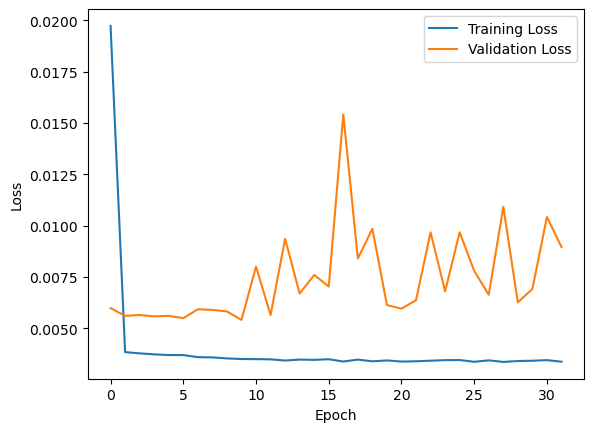

In [147]:
# !pip install -q prodigyopt
try:
    from prodigyopt import Prodigy
except:
    !pip install prodigyopt
    from prodigyopt import Prodigy    
from torch.nn import BCELoss
import torch.nn.functional as F

criterion = BCELoss()
model = MyNN(input_size = X_train.shape[1])

# parallise using 32 CPUs
model = nn.DataParallel(model, device_ids = list(range(CPU_COUNT)))

# optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
optimiser = Prodigy(model.parameters(), lr=0.01, weight_decay=0.0001)


best_model_state = train_nn(model, criterion, optimiser, train_data, test_data, epochs=32)

# save model
# torch.save(best_model_state, f'../models/simple_nn_{name}_13cols_smoted.pt')

In [148]:
torch.save(best_model_state, f'../model/simple_nn_{name}_smoted.pt')

In [ ]:
model_state_dict = torch.load(f'../model/simple_nn_{name}_smoted.pt')


### Pred On Whole Pool

In [205]:
filtered_pool

,patent_id,patent_count,recid,pname_pname_jarowinkler,sname_sname_jarowinkler,county_state_county_state_levenshtein,city_metrous_levenshtein,city_us1880a_city_levenshtein,desc_ori_hisco_text_levenshtein,occ_similarity_HISCO,...,enumdist,countyus,metrous,us1880a_region,us1880a_stateicp,us1880a_city,us1880a_stcounty,us1880a_county,streetcensus,good
0,US263433A,0,17944647,0.550000,0.76,0.64,0.0,0.0,0.217391,NaN,...,1,10,0,11.0,3.0,0,250010.0,10.0,,False
1,US263433A,0,17944648,0.490079,0.76,0.64,0.0,0.0,0.130435,0.094747,...,1,10,0,11.0,3.0,0,250010.0,10.0,,False
2,US263433A,0,17944649,0.324074,0.76,0.64,0.0,0.0,0.239130,NaN,...,1,10,0,11.0,3.0,0,250010.0,10.0,,False
3,US263433A,0,17945395,0.422619,0.73,0.64,0.0,0.0,0.195652,0.095582,...,2,10,0,11.0,3.0,0,250010.0,10.0,,False
4,US263433A,0,17945396,0.438131,0.73,0.64,0.0,0.0,0.217391,NaN,...,2,10,0,11.0,3.0,0,250010.0,10.0,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280859,US292268A,0,16344136,0.555556,1.00,0.56,0.0,0.0,0.256410,None,...,198,1250,0,33.0,45.0,0,221250.0,1250.0,,False
280860,US292268A,0,16344420,0.444444,1.00,0.56,0.0,0.0,0.178571,None,...,198,1250,0,33.0,45.0,0,221250.0,1250.0,,False
280861,US292268A,0,16344421,0.700000,1.00,0.56,0.0,0.0,0.000000,None,...,198,1250,0,33.0,45.0,0,221250.0,1250.0,,False
280862,US292268A,0,16344422,0.539683,1.00,0.56,0.0,0.0,0.000000,None,...,198,1250,0,33.0,45.0,0,221250.0,1250.0,,False


In [217]:
attached_comparison_pool = attached_comparison_pool.set_index(['patent_id',	'patent_count',	'recid'])
attached_comparison_pool['good'] = False
good_indices = attached_comparison_pool.index.intersection(filtered_pool[filtered_pool.good == True].set_index(['patent_id','patent_count','recid']).index)
attached_comparison_pool.loc[good_indices, 'good'] = True
attached_comparison_pool = attached_comparison_pool.reset_index()
attached_comparison_pool.good.value_counts()

#### Define feature lists

In [215]:
comp_features = ['pname_pname_jarowinkler',	'sname_sname_jarowinkler',	'county_state_county_state_levenshtein',	'city_metrous_levenshtein',	'city_us1880a_city_levenshtein']
weak_pred_features = ['gnb_proba',	'cb_proba',	'xgb_proba',	'rf_proba',	'lgbm_proba']
nn_features = comp_features + weak_pred_features
 

#### Run pred

In [192]:
import torch.nn as nn
import torch
name = "80"
# Weak learners
import pickle
import os
from dask_ml.wrappers import ParallelPostFit

def pred_with_existing_models(attached_comparison_pool, nn_model_name = '80', true_threshold_weak_learners = 0.5, true_threshold_nn = 0.9999):
    if 'model_zoo' not in dir():
    # if 'model_zoo' not in globals():
        print(f"model_zoo not loaded, loading...")
        model_dir = '../model/patent_census_match/smoted_5_models_5_cols'
        model_zoo = {}
        
        # read all models in the model_dir
        for model in os.listdir(model_dir):
            with open(f'{model_dir}/{model}', 'rb') as handle:
                # model_zoo[model.split('.')[0]] = pickle.load(handle)
                model_zoo[model.split('.')[0]] = ParallelPostFit(pickle.load(handle))
                # predict using dask version sklearn
                # model = ParallelPostFit(model)
                handle.close()
        print("loaded")
                
    # predict per model in model_zoo and concat the quantile of f'{name}_proba' of each model into df
    stats = pd.DataFrame()
    for name, model in model_zoo.items():
        attached_comparison_pool[f'{name}_proba'] = model_zoo[name].predict_proba(attached_comparison_pool[cluster_features])[:, 1]
    #     stats = pd.concat([stats, attached_comparison_pool.groupby('good')[f'{name}_proba'].quantile([0.05, 0.5, 0.95]).reset_index()], axis = 1)
    # stats
        print(f"weak learner {name} loaded")
        
    # NN
    model_state_dict = torch.load(f'../model/simple_nn_{nn_model_name}_smoted.pt')
    nn_features = comp_features + weak_pred_features
    model = MyNN(input_size=attached_comparison_pool[nn_features].shape[1]) # takes in 18 features:
    try:
        model.load_state_dict(model_state_dict)
    except:
        print(f"fixing state dict...")
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in model_state_dict.items():
            name = k.replace("module.", "")  # remove `module.` if it exists
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
        print('fixed')
    print(f"predicting using NN")    
    attached_comparison_pool['nn'] = model(torch.tensor(attached_comparison_pool[nn_features].values.astype(np.float32))).detach().numpy().squeeze()
    mask_true = attached_comparison_pool.nn > true_threshold_nn
    attached_comparison_pool['nn_bool']  = False
    attached_comparison_pool.loc[mask_true, 'nn_bool'] = True
    print(attached_comparison_pool['nn_bool'].value_counts())
    return attached_comparison_pool
    
attached_comparison_pool = pred_with_existing_models(attached_comparison_pool, nn_model_name = '80', true_threshold_nn = 0.9999)

masks = {}
for name, _ in model_zoo.items():
    masks[name] = attached_comparison_pool[f'{name}_proba'] > true_threshold_weak_learners

masks['nn'] = attached_comparison_pool['nn_bool'] == True
for name, mask in masks.items():
    print(f"Precision for {name} (TP / TP + FP): {attached_comparison_pool[mask & (attached_comparison_pool.good == True)].shape[0] / attached_comparison_pool[mask].shape[0]}")
    print(f"Recall for {name} (TP / TP + FN): {attached_comparison_pool[mask & (attached_comparison_pool.good == True)].shape[0] / attached_comparison_pool[attached_comparison_pool.good == True].shape[0]}")

model_zoo not loaded, loading...
loaded
weak learner gnb loaded
weak learner cb loaded
weak learner xgb loaded
weak learner rf loaded
weak learner lgbm loaded
fixing state dict...
fixed
predicting using NN
nn_bool
False    12344607
True        42267
Name: count, dtype: int64


AttributeError: 'DataFrame' object has no attribute 'good'

In [252]:
mask_true = attached_comparison_pool.nn > 0.99999995
attached_comparison_pool['nn_bool']  = False
attached_comparison_pool.loc[mask_true, 'nn_bool'] = True
masks['nn'] = attached_comparison_pool['nn_bool'] == True
attached_comparison_pool.nn_bool.value_counts()

nn_bool
False    12366584
True        20290
Name: count, dtype: int64

In [253]:
for name, mask in masks.items():
    print(f"Precision for {name} (TP / TP + FP): {attached_comparison_pool[mask & (attached_comparison_pool.good == True)].shape[0] / attached_comparison_pool[mask].shape[0]}")
    print(f"Recall for {name} (TP / TP + FN): {attached_comparison_pool[mask & (attached_comparison_pool.good == True)].shape[0] / attached_comparison_pool[attached_comparison_pool.good == True].shape[0]}")

Precision for gnb (TP / TP + FP): 0.003865647281161412
Recall for gnb (TP / TP + FN): 0.9
Precision for cb (TP / TP + FP): 0.00388644812436634
Recall for cb (TP / TP + FN): 0.92
Precision for xgb (TP / TP + FP): 0.005013578441612701
Recall for xgb (TP / TP + FN): 0.96
Precision for rf (TP / TP + FP): 0.0068242343541944075
Recall for rf (TP / TP + FN): 0.82
Precision for lgbm (TP / TP + FP): 0.004660969925646432
Recall for lgbm (TP / TP + FN): 0.84
Precision for nn (TP / TP + FP): 0.0024149827501232135
Recall for nn (TP / TP + FN): 0.98


Low precision indicates that 
- the weak learner did not learn to a generalise to extremely unbalanced comparing pool (with thershold 0.5, this is unmodifiable as what the NN learned is dependent on this threshold)
- the ensembled model did not learn to adapt to extremely unbalanced comparing pool (with thershold 0.9999)
- It's fine. It means we ultimately will get 42267 / (12344607 + 42267) = 3.5% (before dedup) of the comparison pairs as true matches.
**The ranking is sorted by a likelyhood of being a good match, so we can adjust the sencond threshold to control the good match rate to be within the desired/rational range.**

In [220]:
masks['nn'].value_counts()

nn_bool
False    12344607
True        42267
Name: count, dtype: int64

In [254]:
42267 / (12344607 + 42267)

0.003412241054522715

### Pred On Large

#### Read Matching Pool

In [47]:
name = "80"
cluster_features = ['pname', 'oname', 'sname', 'pname_soundex', 'sname_soundex', 'pname_metaphone', 'sname_metaphone', 'address', 'dateofbirth', 'par_witin_10km', 'birth_par_witin_10km', 'sname_pop_metaphone', 'sex']


In [38]:

matching_pool = dd.read_parquet(f"../Output/temp/{name}_compare_corrected_13/")
matching_pool.columns = ['pname', 'oname', 'sname', 'pname_soundex','sname_soundex',
    'pname_metaphone', 'sname_metaphone', 'address','sname_pop_metaphone', 'dateofbirth', 'sex', 'par_witin_10km', 'birth_par_witin_10km']
matching_pool = matching_pool.reset_index()

matching_pool.birth_par_witin_10km = matching_pool.birth_par_witin_10km.astype(float)
matching_pool.par_witin_10km = matching_pool.par_witin_10km.astype(float)

report_ram_usage()

Current RAM usage: 0.80 GiB


In [40]:
import pickle
with open('../Output/golden_3million.pkl', 'rb') as f:
    gt_index = pickle.load(f)
    
gt = gt_index.to_frame().reset_index(drop=True).reset_index(drop = True)

# Sample the DataFrame
gt = gt.sample(frac=200/gt.shape[0], random_state=42)

gt_index = gt.set_index(['recid61', 'recid51']).index

In [41]:
# filter matching pool: if matching_pool.recid_1 in gt.recid61 or matching_pool.recid_2 in gt.recid51
matching_pool['recid_1'] = matching_pool.recid_1.astype('int64')
matching_pool['recid_2'] = matching_pool.recid_2.astype('int64')

filtered_pool = matching_pool[matching_pool.recid_1.isin(gt_index.get_level_values(0).unique()) | matching_pool.recid_2.isin(gt_index.get_level_values(1).unique())].compute()
filtered_pool['good'] = False
filtered_pool = filtered_pool.set_index(['recid_1', 'recid_2'])
filtered_pool.loc[gt_index, 'good'] = True
filtered_pool = filtered_pool.reset_index()

#### Base Models pred_proba

In [228]:
sample = filtered_pool
sample

,,pname,oname,sname,pname_soundex,sname_soundex,pname_metaphone,sname_metaphone,address,sname_pop_metaphone,dateofbirth,...,par_witin_10km,birth_par_witin_10km,good,gnb_proba,cb_proba,xgb_proba,rf_proba,lgbm_proba,nn,nn_bool
recid_1,recid_2,,,,,,,,,,,,,,,,,,,,,
8249,649103,1.0,0.0,0.933333,1.0,1.0,1.0,1.00,0.260870,0.00,1.455192e-11,...,0.0,1.0,False,2.259794e-11,6.404324e-07,7.218477e-07,0.0,0.000022,2.258350e-01,False
1678,1809666,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.250000,1.00,5.000000e-01,...,0.0,0.0,False,2.978048e-04,1.056929e-06,7.817179e-08,0.0,0.000051,2.507222e-09,False
18776,807807,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.562500,1.00,1.058432e-01,...,0.0,0.0,False,6.427144e-09,8.872870e-07,1.088455e-06,0.0,0.000041,7.180376e-11,False
15200,268260,1.0,0.0,0.960000,1.0,1.0,1.0,0.96,0.111111,0.96,3.312022e-04,...,1.0,0.0,False,6.943316e-95,2.783251e-07,5.552781e-07,0.0,0.000022,5.877947e-08,False
12750,509139,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.263158,0.00,1.845301e-02,...,0.0,0.0,False,1.162984e-13,5.941130e-08,7.816433e-08,0.0,0.000022,6.980568e-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19801242,15966621,1.0,0.0,0.971429,1.0,1.0,1.0,1.00,0.117647,0.00,4.364403e-03,...,0.0,0.0,False,1.205271e-14,1.381541e-08,1.030117e-07,0.0,0.000022,6.103911e-01,False
19801003,7197604,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.076923,0.00,1.525879e-05,...,0.0,0.0,False,3.676503e-14,2.971059e-08,1.236393e-07,0.0,0.000022,5.505207e-01,False
19805460,7197604,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.076923,0.00,4.675320e-13,...,0.0,0.0,False,3.673729e-14,2.971059e-08,1.236393e-07,0.0,0.000022,5.505131e-01,False


In [229]:
# read back
import pickle
import os
from dask_ml.wrappers import ParallelPostFit
model_dir = f'../models/simple_bt_{name}_13cols_smoted/'
model_zoo = {}

wrap_dask = False
# read all models in the model_dir
for model in os.listdir(model_dir):
    with open(f'{model_dir}{model}', 'rb') as handle:
        if wrap_dask:
            model_zoo[model.split('.')[0]] = ParallelPostFit(pickle.load(handle))
        else:
            model_zoo[model.split('.')[0]] = pickle.load(handle)
        # predict using dask version sklearn
        # model = ParallelPostFit(model)
        handle.close()


In [230]:
for name, model in model_zoo.items():
    sample[f'{name}_proba'] = model_zoo[name].predict_proba(sample[cluster_features])[:, 1]

In [231]:
sample

,,pname,oname,sname,pname_soundex,sname_soundex,pname_metaphone,sname_metaphone,address,sname_pop_metaphone,dateofbirth,...,par_witin_10km,birth_par_witin_10km,good,gnb_proba,cb_proba,xgb_proba,rf_proba,lgbm_proba,nn,nn_bool
recid_1,recid_2,,,,,,,,,,,,,,,,,,,,,
8249,649103,1.0,0.0,0.933333,1.0,1.0,1.0,1.00,0.260870,0.00,1.455192e-11,...,0.0,1.0,False,2.259794e-11,6.404324e-07,7.218477e-07,0.0,0.000022,2.258350e-01,False
1678,1809666,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.250000,1.00,5.000000e-01,...,0.0,0.0,False,2.978048e-04,1.056929e-06,7.817179e-08,0.0,0.000051,2.507222e-09,False
18776,807807,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.562500,1.00,1.058432e-01,...,0.0,0.0,False,6.427144e-09,8.872870e-07,1.088455e-06,0.0,0.000041,7.180376e-11,False
15200,268260,1.0,0.0,0.960000,1.0,1.0,1.0,0.96,0.111111,0.96,3.312022e-04,...,1.0,0.0,False,6.943316e-95,2.783251e-07,5.552781e-07,0.0,0.000022,5.877947e-08,False
12750,509139,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.263158,0.00,1.845301e-02,...,0.0,0.0,False,1.162984e-13,5.941130e-08,7.816433e-08,0.0,0.000022,6.980568e-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19801242,15966621,1.0,0.0,0.971429,1.0,1.0,1.0,1.00,0.117647,0.00,4.364403e-03,...,0.0,0.0,False,1.205271e-14,1.381541e-08,1.030117e-07,0.0,0.000022,6.103911e-01,False
19801003,7197604,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.076923,0.00,1.525879e-05,...,0.0,0.0,False,3.676503e-14,2.971059e-08,1.236393e-07,0.0,0.000022,5.505207e-01,False
19805460,7197604,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.076923,0.00,4.675320e-13,...,0.0,0.0,False,3.673729e-14,2.971059e-08,1.236393e-07,0.0,0.000022,5.505131e-01,False


In [217]:
# # set_index
# sample.set_index(['recid_1', 'recid_2'], inplace = True)

KeyError: "None of ['recid_1', 'recid_2'] are in the columns"

#### NN pred

In [232]:
import torch.nn as nn
import torch
name = "80"
model_state_dict = torch.load(f'../model/simple_nn_{name}_smoted.pt')
nn_features = ['pname',
 'oname',
 'sname',
 'pname_soundex',
 'sname_soundex',
 'pname_metaphone',
 'sname_metaphone',
 'address',
 'dateofbirth',
 'par_witin_10km',
 'birth_par_witin_10km',
 'sname_pop_metaphone',
 'sex',
 'gnb_proba',
 'cb_proba',
 'xgb_proba',
 'rf_proba',
 'lgbm_proba']
model = MyNN(input_size=sample[nn_features].shape[1]) # takes in 18 features:
model.load_state_dict(model_state_dict)

sample['nn'] = model(torch.tensor(sample[nn_features].values.astype(np.float32))).detach().numpy().squeeze()
mask_true = sample.nn > 0.9999
sample['nn_bool']  = False
sample.loc[mask_true, 'nn_bool'] = True
sample['nn_bool'].value_counts()

# pred using torch model
# model(test_data)

nn_bool
False    20010
True       292
Name: count, dtype: int64

In [221]:
sample.nn.max()

1.0

<Axes: ylabel='Frequency'>

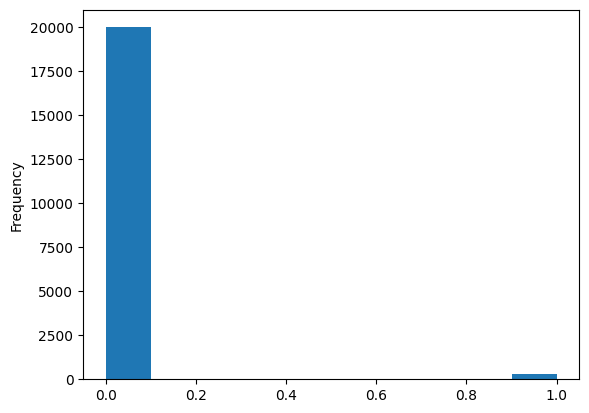

In [222]:
sample.nn_bool.astype('int').plot.hist()

In [233]:
print(f"Precision for {'NN'} (TP / TP + FP): {sample[mask_true & (sample.good == True)].shape[0] / sample[mask_true].shape[0]}")
print(f"Recall for {'NN'} (TP / TP + FN): {sample[mask_true & (sample.good == True)].shape[0] / sample[sample.good == True].shape[0]}")

Precision for NN (TP / TP + FP): 0.6815068493150684
Recall for NN (TP / TP + FN): 0.995


In [224]:
# sample = sample.reset_index()
sample

,,pname,oname,sname,pname_soundex,sname_soundex,pname_metaphone,sname_metaphone,address,sname_pop_metaphone,dateofbirth,...,par_witin_10km,birth_par_witin_10km,good,gnb_proba,cb_proba,xgb_proba,rf_proba,lgbm_proba,nn,nn_bool
recid_1,recid_2,,,,,,,,,,,,,,,,,,,,,
8249,649103,1.0,0.0,0.933333,1.0,1.0,1.0,1.00,0.260870,0.00,1.455192e-11,...,0.0,1.0,False,2.259794e-11,6.404324e-07,7.218477e-07,0.0,0.000022,2.258350e-01,False
1678,1809666,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.250000,1.00,5.000000e-01,...,0.0,0.0,False,2.978048e-04,1.056929e-06,7.817179e-08,0.0,0.000051,2.507222e-09,False
18776,807807,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.562500,1.00,1.058432e-01,...,0.0,0.0,False,6.427144e-09,8.872870e-07,1.088455e-06,0.0,0.000041,7.180376e-11,False
15200,268260,1.0,0.0,0.960000,1.0,1.0,1.0,0.96,0.111111,0.96,3.312022e-04,...,1.0,0.0,False,6.943316e-95,2.783251e-07,5.552781e-07,0.0,0.000022,5.877947e-08,False
12750,509139,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.263158,0.00,1.845301e-02,...,0.0,0.0,False,1.162984e-13,5.941130e-08,7.816433e-08,0.0,0.000022,6.980568e-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19801242,15966621,1.0,0.0,0.971429,1.0,1.0,1.0,1.00,0.117647,0.00,4.364403e-03,...,0.0,0.0,False,1.205271e-14,1.381541e-08,1.030117e-07,0.0,0.000022,6.103911e-01,False
19801003,7197604,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.076923,0.00,1.525879e-05,...,0.0,0.0,False,3.676503e-14,2.971059e-08,1.236393e-07,0.0,0.000022,5.505207e-01,False
19805460,7197604,1.0,0.0,1.000000,1.0,1.0,1.0,1.00,0.076923,0.00,4.675320e-13,...,0.0,0.0,False,3.673729e-14,2.971059e-08,1.236393e-07,0.0,0.000022,5.505131e-01,False


#### Look at Pred

In [ ]:
subSample1851 = dd.read_parquet("../Census_samples/Whole_proc/Whole_1851_mom_pop_sp").reset_index().compute()
subSample1861 = dd.read_parquet("../Census_samples/Whole_proc/Whole_1861_mom_pop_sp").reset_index().compute()

#### De-duplication

In [235]:
sample = sample.reset_index()

In [236]:
# # 51 then 61
# sample = sample.sort_values(['recid_2', 'nn'], ascending = [True, False]).drop_duplicates(subset = ['recid_2'], keep = 'first')
# print(sample.nn_bool.value_counts())
# sample = sample.sort_values(['recid_1', 'nn'], ascending = [True, False]).drop_duplicates(subset = ['recid_1'], keep = 'first')
# print(sample.nn_bool.value_counts())

nn_bool
False    10303
True       241
Name: count, dtype: int64
nn_bool
True     206
False      5
Name: count, dtype: int64


In [226]:
# 61 then 51
sample = sample.sort_values(['recid_1', 'nn'], ascending = [True, False]).drop_duplicates(subset = ['recid_1'], keep = 'first')
print(sample.nn_bool.value_counts())
sample = sample.sort_values(['recid_2', 'nn'], ascending = [True, False]).drop_duplicates(subset = ['recid_2'], keep = 'first')
print(sample.nn_bool.value_counts())

assert sample.recid_1.nunique() == sample.shape[0]
assert sample.recid_2.nunique() == sample.shape[0]

In [242]:
def attach_ori_feature(to_attach, to_attach_recid_left, to_attach_recid_right, left_df, right_df, suffixes):
    to_attach = to_attach.merge(left_df, left_on = to_attach_recid_left, right_on = 'recid', how = 'left')
    to_attach = to_attach.merge(right_df, left_on = to_attach_recid_right, right_on = 'recid', how = 'left', suffixes = suffixes)
    return to_attach

attached = attach_ori_feature(sample[['recid_1', 'recid_2', 'nn_bool', 'nn']], 'recid_1', 'recid_2', subSample1861, subSample1851, ['_61', '_51'])
attached

,recid_1,recid_2,nn_bool,nn,index_61,year_x_61,recid_61,title_61,pname_61,oname_61,...,pname_pop_soundex_51,sname_pop_soundex_51,pname_sp_soundex_51,sname_sp_soundex_51,pname_mom_metaphone_51,sname_mom_metaphone_51,pname_pop_metaphone_51,sname_pop_metaphone_51,pname_sp_metaphone_51,sname_sp_metaphone_51
0,12750,37121,True,1.000000,12749,1861,12750,,ANN,,...,J520,M624,None,None,AN,MRXL,JMS,MRXL,None,None
1,155529,268260,True,1.000000,155528,1861,155529,,ANN,,...,J500,W452,None,None,HRT,WLMS,JN,WLMS,None,None
2,344342,8697291,True,1.000000,344341,1861,344342,,WILLIAM,,...,None,None,None,None,None,None,None,None,None,None
3,459866,9866755,True,1.000000,459865,1861,459866,,MARY,,...,None,None,D130,D000,None,None,None,None,TFT,T
4,488324,611687,True,1.000000,488323,1861,488324,,GEORGE,,...,E150,E152,None,None,ELNR,EFNS,EFN,EFNS,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,19388761,17360928,True,0.999995,19388760,1861,19388761,,EDWARD,,...,None,None,L200,D120,None,None,None,None,LS,TFS
207,19397442,17374253,True,1.000000,19397441,1861,19397442,,HUGH,,...,D130,R163,None,None,JN,RBRTS,TFT,RBRTS,None,None
208,19440143,17416865,True,1.000000,19440142,1861,19440143,,WILLIAM,,...,None,None,None,None,None,None,None,None,None,None
209,19445318,17427902,True,1.000000,19445317,1861,19445318,,WILLIAM,,...,P620,J520,None,None,ALS,JNS,PRS,JNS,None,None


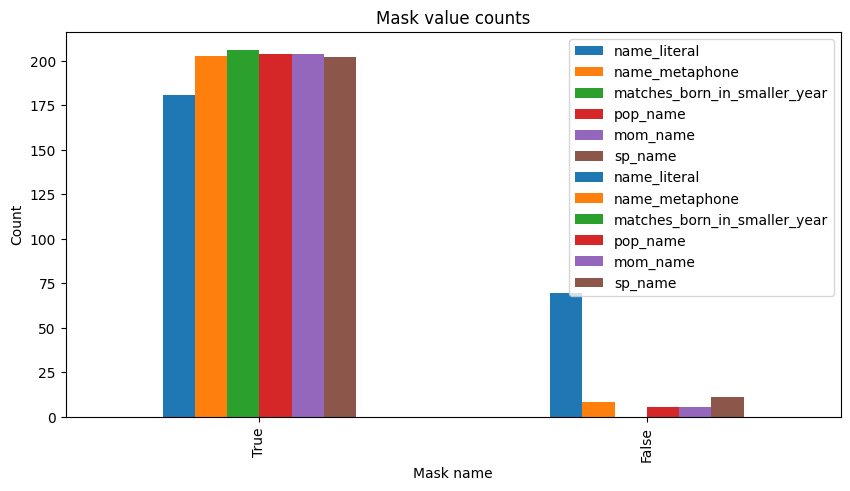

0      True
1      True
2      True
3      True
4      True
       ... 
206    True
207    True
208    True
209    True
210    True
Length: 206, dtype: bool


/tmp/ipykernel_17474/1752311303.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  optimistic_precision = look[mask_TP_optimistic].shape[0] / look[mask_pred_Positive].shape[0]
/tmp/ipykernel_17474/1752311303.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  precision_safe_ground = look[mask_TP].shape[0] / look[mask_pred_Positive].shape[0]


(      name_literal name_soundex name_metaphone matches_born_in_smaller_year  \
 True         181.0        206.0          203.0                        206.0   
 False           25         <NA>              3                          NaN   
 
       pop_name mom_name sp_name  
 True     204.0    204.0   202.0  
 False        2        2       4  ,
    optimistic_precision  precision  matching_rate_1861  matching_rate_1851
 0                   1.0   0.970874            0.020687            0.019537)

In [246]:
def mask_validation(pred_look, pred, recid_left = 'recid_1', recid_right = 'recid_2', metrics = False, whole_mt_pool = False, only_true = False):
    """
    This code block defines several masks for filtering data based on certain conditions.
    The masks are used to select specific rows from the dataset.
    - `mask_matches_not_born_in_smaller_year`: A mask that filters rows where the age in 1861 is less than 10.
    - `mask_pop_name`: A mask that filters rows where the population soundex names in 1861 and 1851 match, or if either of them is missing.
    - `mask_mom_name`: A mask that filters rows where the mother's soundex names in 1861 and 1851 match, or if either of them is missing.
    - `mask_spoouse_name`: A mask that filters rows where the spouse's soundex names in 1861 and 1851 match, or if either of them is missing.
    """
    masks = {}
    # masks
    mask_pred_Positive = pred_look[pred] == True
    if only_true == False:
        # back_up = pred_look.copy()
        pred_look = pred_look[mask_pred_Positive]

    def define_masks(df):
        # general
        mask_matches_born_in_smaller_year = df.uk1861a_age >= 10
        # mask_name = df.pname_61 == df.pname_51
        mask_name_literal = ((df.pname_61 == df.pname_51) & (df.sname_61 == df.sname_51)) | (df.pname_61.isna() | df.pname_51.isna())
        mask_name_soundex = ((df.pname_soundex_61 == df.pname_soundex_51) & (df.sname_soundex_61 == df.sname_soundex_51)) | (df.pname_soundex_61.isna() | df.pname_soundex_51.isna())
        mask_name_metaphone = ((df.pname_metaphone_61 == df.pname_metaphone_51) & (df.sname_metaphone_61 == df.sname_metaphone_51)) | (df.pname_metaphone_61.isna() | df.pname_metaphone_51.isna())

        # fam 
        mask_pop_name = ((df.pname_pop_soundex_61 == df.pname_pop_soundex_51) & (df.sname_pop_soundex_61 == df.sname_pop_soundex_51)) | (df.pname_pop_soundex_61.isna() | df.pname_pop_soundex_51.isna())
        mask_mom_name = ((df.pname_mom_soundex_61 == df.pname_mom_soundex_51) & (df.sname_mom_soundex_61 == df.sname_mom_soundex_51)) | (df.pname_mom_soundex_61.isna() | df.pname_mom_soundex_51.isna())
        mask_sp_name = ((df.pname_sp_soundex_61 == df.pname_sp_soundex_51) & (df.sname_sp_soundex_61 == df.sname_sp_soundex_51)) | (df.pname_sp_soundex_61.isna() | df.pname_sp_soundex_51.isna())

        # make all value_counts of masks into a dataframe
        st = pd.DataFrame([mask_name_literal.value_counts().rename('name_literal'), \
                            mask_name_soundex.value_counts().rename('name_soundex'), \
                            mask_name_metaphone.value_counts().rename('name_metaphone'), \
                            mask_matches_born_in_smaller_year.value_counts().rename('matches_born_in_smaller_year'), \
                            mask_pop_name.value_counts().rename('pop_name'), \
                            mask_mom_name.value_counts().rename('mom_name'), \
                            mask_sp_name.value_counts().rename('sp_name')])
        # return all the masks
        return st, mask_name_literal, mask_name_soundex, mask_name_metaphone, mask_matches_born_in_smaller_year, mask_pop_name, mask_mom_name, mask_sp_name
    
    # run the function
    st, mask_name_literal, mask_name_soundex, mask_name_metaphone, mask_matches_born_in_smaller_year, mask_pop_name, mask_mom_name, mask_sp_name = define_masks(pred_look)

    # format cell numiber to human readable
    st.style.format("{:,}")
    # make a visualization of percentage of each mask
    fig, ax = plt.subplots(figsize=(10, 5))
    # translate all numbers to perventage to pred_look[0], pay attention to NaN
    st.T.div(st.T.sum(axis=1), axis=0).mul(100).plot.bar(ax=ax)
    st.T.plot.bar(ax=ax)
    ax.set_title("Mask value counts")
    ax.set_xlabel("Mask name")
    ax.set_ylabel("Count")
    plt.show()


    def metrics(look, intermediate = filtered_pool.reset_index(), whole_mt_pool = False):
        '''
        calculate optimistic precision, precision, recall, f1 score
        '''
        st, mask_name_literal, mask_name_soundex, mask_name_metaphone, mask_matches_born_in_smaller_year, mask_pop_name, mask_mom_name, mask_sp_name = define_masks(look)
        print(mask_pop_name | mask_mom_name | mask_sp_name)
        mask_TP_optimistic = mask_pop_name | mask_mom_name | mask_sp_name
        mask_TP = mask_pop_name & mask_mom_name & mask_sp_name
        # optimistic precision
        optimistic_precision = look[mask_TP_optimistic].shape[0] / look[mask_pred_Positive].shape[0]
        # precision
        precision_safe_ground = look[mask_TP].shape[0] / look[mask_pred_Positive].shape[0]
        # recall
        if whole_mt_pool:
            matching_rate_1861 = look[look[pred] == True][recid_left].nunique() / subSample1861.recid.nunique() 
            matching_rate_1851 = look[look[pred] == True][recid_right].nunique() / subSample1851.recid.nunique() 
        else:
            matching_rate_1861 = look[look[pred] == True][recid_left].nunique() / intermediate.recid_1.nunique() 
            matching_rate_1851 = look[look[pred] == True][recid_right].nunique() / intermediate.recid_2.nunique()
        # return a tuple
        # return (optimistic_precision, precision, matching_rate_1861, matching_rate_1851)

        # format to 2 decimal places
        stats = pd.DataFrame({'optimistic_precision': [optimistic_precision], \
                             'precision': [precision_safe_ground], \
                             'matching_rate_1861': [matching_rate_1861], \
                             'matching_rate_1851': [matching_rate_1851]
                            }
                            )
        stats.style.format("{:.2f}", na_rep="-", subset=['optimistic_precision', 'precision', \
                                                         'matching_rate_1861', 'matching_rate_1851'
                                                         ]
                                                         )
        return stats
    
    if metrics:
        return st.T, metrics(pred_look)
    else:
        return st.T

# sample['pred'] = True
mask_validation(attached, pred = 'nn_bool', metrics = True)

## Evaluate the result of ML

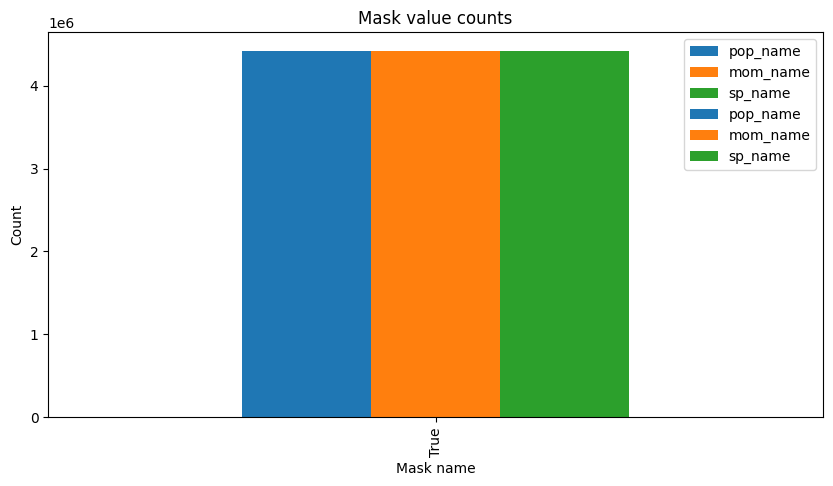

(      pop_name  mom_name  sp_name
 True   4423574   4423574  4423574,
    optimistic_precision  precision  matching_rate_1861  matching_rate_1851
 0                   1.0        1.0            0.223091            0.249764)

In [73]:
def mask_validation(pred_look, model = None, metrics = False):
    """
    This code block defines several masks for filtering data based on certain conditions.
    The masks are used to select specific rows from the dataset.
    - `mask_matches_not_born_in_smaller_year`: A mask that filters rows where the age in 1861 is less than 10.
    - `mask_pop_name`: A mask that filters rows where the population soundex names in 1861 and 1851 match, or if either of them is missing.
    - `mask_mom_name`: A mask that filters rows where the mother's soundex names in 1861 and 1851 match, or if either of them is missing.
    - `mask_spoouse_name`: A mask that filters rows where the spouse's soundex names in 1861 and 1851 match, or if either of them is missing.
    """
    # masks
    # mask_name_literal = ((pred_look.pname_61 == pred_look.pname_51) & (pred_look.sname_61 == pred_look.sname_51)) | (pred_look.pname_61.isna() | pred_look.pname_51.isna())
    # mask_name_soundex = ((pred_look.pname_soundex_61 == pred_look.pname_soundex_51) & (pred_look.sname_soundex_61 == pred_look.sname_soundex_51)) | (pred_look.pname_soundex_61.isna() | pred_look.pname_soundex_51.isna())
    # mask_name_metaphone = ((pred_look.pname_metaphone_61 == pred_look.pname_metaphone_51) & (pred_look.sname_metaphone_61 == pred_look.sname_metaphone_51)) | (pred_look.pname_metaphone_61.isna() | pred_look.pname_metaphone_51.isna())
    # general
    # mask_matches_born_in_smaller_year = pred_look.uk1861a_age >= 10
    # mask_name = pred_look.pname_61 == pred_look.pname_51

    # fam 
    mask_pop_name = ((pred_look.pname_pop_soundex_61 == pred_look.pname_pop_soundex_51) & (pred_look.sname_pop_soundex_61 == pred_look.sname_pop_soundex_51)) | (pred_look.pname_pop_soundex_61.isna() | pred_look.pname_pop_soundex_51.isna())
    mask_mom_name = ((pred_look.pname_mom_soundex_61 == pred_look.pname_mom_soundex_51) & (pred_look.sname_mom_soundex_61 == pred_look.sname_mom_soundex_51)) | (pred_look.pname_mom_soundex_61.isna() | pred_look.pname_mom_soundex_51.isna())
    mask_sp_name = ((pred_look.pname_sp_soundex_61 == pred_look.pname_sp_soundex_51) & (pred_look.sname_sp_soundex_61 == pred_look.sname_sp_soundex_51)) | (pred_look.pname_sp_soundex_61.isna() | pred_look.pname_sp_soundex_51.isna())

    # make all value_counts of masks into a dataframe
    st = pd.DataFrame([ \
                        # mask_name_literal.value_counts().rename('name_literal'), \
                        #   mask_name_soundex.value_counts().rename('name_soundex'), \
                        #   mask_name_metaphone.value_counts().rename('name_metaphone'), \
                        #   mask_matches_born_in_smaller_year.value_counts().rename('matches_born_in_smaller_year'), \
                        #   mask_name.value_counts().rename('name'), \
                          mask_pop_name.value_counts().rename('pop_name'), \
                          mask_mom_name.value_counts().rename('mom_name'), \
                          mask_sp_name.value_counts().rename('sp_name')])
    # format cell numiber to human readable
    st.style.format("{:,}")
    # make a visualization of percentage of each mask
    fig, ax = plt.subplots(figsize=(10, 5))
    # translate all numbers to perventage to pred_look[0], pay attention to NaN
    st.T.div(st.T.sum(axis=1), axis=0).mul(100).plot.bar(ax=ax)
    st.T.plot.bar(ax=ax)
    ax.set_title("Mask value counts")
    ax.set_xlabel("Mask name")
    ax.set_ylabel("Count")
    plt.show()


    def metrics(pred_look):
        '''
        calculate optimistic precision, precision, recall, f1 score
        '''
        # optimistic precision
        optimistic_precision = pred_look[mask_pop_name | mask_mom_name | mask_sp_name].shape[0] / pred_look.shape[0]
        safe_ground = pred_look[mask_pop_name & mask_mom_name & mask_sp_name] 
        # precision
        precision = safe_ground.shape[0] / pred_look.shape[0]
        # recall
        if 'recid61' in pred_look.columns and 'recid51' in pred_look.columns:
            if model == None:
                matching_rate_1861 = pred_look[pred_look.pred == True].recid61.nunique() / subSample1861.recid.nunique() 
                matching_rate_1851 = pred_look[pred_look.pred == True].recid51.nunique() / subSample1851.recid.nunique() 
            else:
                matching_rate_1861 = pred_look[pred_look[f'{model}_pred'] == True].recid61.nunique() / subSample1861.recid.nunique() 
                matching_rate_1851 = pred_look[pred_look[f'{model}_pred'] == True].recid51.nunique() / subSample1851.recid.nunique()
        else:
            if model == None:
                matching_rate_1861 = pred_look[pred_look.pred == True].recid_1.nunique() / subSample1861.recid.nunique() 
                matching_rate_1851 = pred_look[pred_look.pred == True].recid_2.nunique() / subSample1851.recid.nunique()
            else: 
                matching_rate_1861 = pred_look[pred_look[f'{model}_pred'] == True].recid_1.nunique() / subSample1861.recid.nunique() 
                matching_rate_1851 = pred_look[pred_look[f'{model}_pred'] == True].recid_2.nunique() / subSample1851.recid.nunique()
        # return a tuple
        # return (optimistic_precision, precision, matching_rate_1861, matching_rate_1851)

        # format to 2 decimal places
        stats = pd.DataFrame({'optimistic_precision': [optimistic_precision], \
                             'precision': [precision], \
                             'matching_rate_1861': [matching_rate_1861], \
                             'matching_rate_1851': [matching_rate_1851]})
        stats.style.format("{:.2f}", na_rep="-", subset=['optimistic_precision', 'precision', 'matching_rate_1861', 'matching_rate_1851'])
        return stats
    
    if metrics:
        return st.T, metrics(pred_look)
    else:
        return st.T

concated_pred['pred'] = True
mask_validation(concated_pred, metrics = True)